# MiniProject 2: Multi-Class Logistic Regression and Gradient Descent
## COMP 551
### David Castonguay (260804528), Marco Guida (260803123), Sean Smith (260787775)

In [1]:
import numpy as np
import numpy.linalg as lia
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn import svm 
from sklearn import datasets
from sklearn.datasets import fetch_openml
from sklearn.naive_bayes import GaussianNB
import time

In [2]:
#run_search will perform the gridsearch in order to run the tests to plot graphs
#if run_search = False, there will be no plots
#ONLY TURN RUN_SEARCH TO TRUE IF YOU HAVE 5 HOURS TO SPARE
run_search = False

## Dataset normalisation

In [3]:
digits = datasets.load_digits()
wine = fetch_openml(name='wine', version=1)

In [4]:
# normalization of digits and wine data

digits_data_norm = []

for col in digits.data:
    col_norm = col/np.max(col)
    digits_data_norm.append(col_norm)

digits.data = np.asarray(digits_data_norm)

wine_data_norm = []

for col in wine.data.T:
    col_norm = col/np.amax(col)
    wine_data_norm.append(col_norm)
    
wine.data = np.asarray(wine_data_norm).T

## Five-fold cross validation

In [5]:
# 5-fold cross validation for digits dataset

digitsTrainingSetSize = int(np.ceil(0.8 * len(digits.data)))
digitsValidationSetSize = int(len(digits.data) - digitsTrainingSetSize)

xDigitsTrainingSets = []
yDigitsTrainingSets = []
xDigitsValidationSets = []
yDigitsValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []

    for index, data in enumerate(digits.data[foldIndex*digitsValidationSetSize:((foldIndex*digitsValidationSetSize)+digitsValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(digits.target[index+(foldIndex*digitsValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []

    for index, data in enumerate(digits.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(digits.target[index])
            
    xDigitsTrainingSets.append(xTrainingSet)
    yDigitsTrainingSets.append(yTrainingSet)
    xDigitsValidationSets.append(xValidationSet)
    yDigitsValidationSets.append(yValidationSet)
    
# 5-fold cross validation for wine dataset

wineTrainingSetSize = int(np.ceil(0.8 * len(wine.data)))
wineValidationSetSize = int(len(wine.data) - wineTrainingSetSize)

xWineTrainingSets = []
yWineTrainingSets = []
xWineValidationSets = []
yWineValidationSets = []

for foldIndex in range(5):

    xValidationSet = []
    yValidationSet = []
    for index, data in enumerate(wine.data[foldIndex*wineValidationSetSize:((foldIndex*wineValidationSetSize)+wineValidationSetSize)]):
        xValidationSet.append(data.tolist())
        yValidationSet.append(wine.target[index+(foldIndex*wineValidationSetSize)])
    
    xTrainingSet = []
    yTrainingSet = []
    
    for index, data in enumerate(wine.data.tolist()):
        if data not in xValidationSet:
            xTrainingSet.append(data)
            yTrainingSet.append(wine.target[index])
            
    xWineTrainingSets.append(xTrainingSet)
    yWineTrainingSets.append(yTrainingSet)
    xWineValidationSets.append(xValidationSet)
    yWineValidationSets.append(yValidationSet)

## One-hot encoding

In [ ]:
# one-hot encoding of y for digits dataset

numberOfDigitsTargets = 10
numberOfWineTargets = 3

for index, fold in enumerate(yDigitsTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yDigitsValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfDigitsTargets)
        encoding[y] = 1
        encodedFold.append(encoding.tolist())
    yDigitsValidationSets[index] = encodedFold

# one-hot encoding of y for wine dataset

for index, fold in enumerate(yWineTrainingSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineTrainingSets[index] = encodedFold
    
for index, fold in enumerate(yWineValidationSets):
    encodedFold = []
    for i, y in enumerate(fold):
        encoding = np.zeros(numberOfWineTargets)
        encoding[int(y)-1] = 1
        encodedFold.append(encoding.tolist())
    yWineValidationSets[index] = encodedFold


In [7]:
def getRandomIndices(arr, batch_size):
    indices = []
    
    if batch_size > len(arr):
        print("Error: batch size larger than size of dataset.")
        return
    
    while batch_size > 0:
        x = np.floor(np.random.random() * len(arr))
        if x not in indices:
            indices.append(int(x))
            batch_size -= 1
    
    return indices

## Logistic Regression

In [8]:
# gradient descent class
 
class GradientDescent:
    
    def __init__(self, batch_size, learning_rate=0.5, momentum=0.9, max_termination_condition=25, max_iters=1000):
        self.learning_rate = learning_rate
        self.momentum = momentum
        self.batch_size = batch_size
        self.max_termination_condition = max_termination_condition
        self.max_iters = max_iters
        self.deltas = []
        
    def run(self, gradient_fn, x, y, w, vx, vy):
        t = 1
        
        max_cost = np.inf
        termination_count = 0        
        weight_history = []
        error_history = []
                
        for number_of_targets in range(len(y[0])):
            weight_history.append([])
        
        while termination_count < self.max_termination_condition and t < self.max_iters:
            gradients = gradient_fn(x, y, w, self.batch_size)   
            
            for c in range(len(y[0])):
                if(t==1):
                    w[c] = w[c] - self.learning_rate * gradients[c]
                else:
                    delta_w = (self.momentum)*(self.deltas[-(len(y[0]))]) + (1-self.momentum)*gradients[c]
                    w[c] = w[c] - (self.learning_rate)*(delta_w)
                self.deltas.append(w[c])
            
            a = np.asarray(vx)
            b = np.asarray(w)
    
            vyh=[]
        
            for i, vx_c in enumerate(a):
                vyh_x=[]

                for c in range(len(b)):
                    w_x =  b[c] @ vx_c
                    num = np.exp(w_x)

                    den = 0
                    
                    for i in range(len(b)):
                        w_x =  b[i] @ vx_c
                        den += np.exp(w_x)

                    vyh_c = num/den
                    vyh_x.append(vyh_c)
                    
                vyh.append(vyh_x)
                
            step_cost = 0
                
            def cost(yh, y):
                return y * np.log1p(np.exp(-yh)) + (1-yh) * np.log1p(np.exp(yh))
                
            for sample_index, vyh_x in enumerate(vyh):
                c = np.argmax(vy[sample_index])
                cst = cost(vyh_x[c], vy[sample_index][c])
                step_cost += cst
            
            for c in range(len(b)):
                weight_history[c].append(w[c])
            
            error_history.append(step_cost)

            if step_cost < max_cost:
                max_cost = step_cost
                termination_count = 0
                print(f"\t\tStep {t}: new best cost of {step_cost:.3f}")
            else:
                termination_count += 1
                print(f"\t\tStep {t}")
            
            t += 1
        
        index_best = len(error_history)-self.max_termination_condition-1
        
        w_best = []
        
        for c in range(len(y[0])):
            w_best.append(weight_history[c][index_best])
        
        return w_best

In [9]:
# logistic regression

class LogisticRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer, vx, vy):
        def gradient(x, y, w, batch_size):
            gradients = np.zeros(len(w)).tolist()

            indices = getRandomIndices(x, batch_size)

            for index in indices:
                a = np.asarray(x[index])
                b = np.asarray(y[index])

                for c in range(len(b)):
                    w_x =  w[c] @ a
                    num = np.exp(w_x)

                    den = 0
                    for i in range(len(b)):
                        w_x =  w[i] @ a
                        den += np.exp(w_x)

                    yh_c = num/den

                    y_c = b[c]
                    
                    cost_c = np.dot(yh_c - y_c, a)
                    
                    gradients[c] += cost_c

            return gradients
        
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
            
            vx = np.asarray(vx)
            vN = vx.shape[0]
            vx = np.column_stack([vx,np.ones(vN)])

        w0 = []
        for c in range(len(y[0])):
            w0.append(np.zeros(len(x[0])))
            
        self.w = optimizer.run(gradient, x, y, w0, vx, vy)
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.asarray(x)
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])

        a = np.asarray(x)
        b = np.asarray(self.w)

        yh=[]
        
        for i, x_c in enumerate(a):
            yh_x=[]
            
            for c in range(len(b)):
                w_x =  b[c] @ x_c
                num = np.exp(w_x)

                den = 0
                
                for i in range(len(b)):
                    w_x =  b[i] @ x_c
                    den += np.exp(w_x)

                yh_c = num/den
                yh_x.append(yh_c)
                
            yh.append(yh_x)
        
        return yh

In [10]:
def runLogisticRegression(batch_size, learning_rate, momentum):
    def accurate(a, b):
        return np.argmax(a) == np.argmax(b)

    def cost(yh, y):
        return y * np.log1p(np.exp(-yh)) + (1-yh) * np.log1p(np.exp(yh))

    print("Model hyper-parameters:")
    print("\tMini-batch size:", batch_size)
    print("\tLearning rate:", learning_rate)
    print("\tMomentum:", momentum)
    print("\n")

    digits_training_accuracy = 0
    digits_training_cost = 0
    digits_validation_accuracy = 0
    digits_validation_cost = 0
    digits_runtime = 0
    wine_runtime = 0
    
    print("Digits gradient descent:")

    for fold_index, fold in enumerate(xDigitsTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        # Record amount of time taken for fit        
        startTime_fit = int(round(time.time() * 1000)) # Milliseconds
        logisticRegressionModel.fit(fold, yDigitsTrainingSets[fold_index], gradientDescentModel, xDigitsValidationSets[fold_index], yDigitsValidationSets[fold_index])
        endTime_fit = -1 * (startTime_fit - int(round(time.time() * 1000))) # <------------
        digits_runtime += endTime_fit
        
        yh_training = logisticRegressionModel.predict(xDigitsTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xDigitsValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yDigitsTrainingSets[fold_index][sample_index]):
                digits_training_accuracy += 1
            c = np.argmax(yDigitsTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsTrainingSets[fold_index][sample_index][c])
            digits_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yDigitsValidationSets[fold_index][sample_index]):
                digits_validation_accuracy += 1
            c = np.argmax(yDigitsValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yDigitsValidationSets[fold_index][sample_index][c])
            digits_validation_cost += cst

    digits_training_accuracy /= 4*len(digits.data)
    digits_training_cost /= 4
    digits_validation_accuracy /= len(digits.data)

    wine_training_accuracy = 0
    wine_training_cost = 0
    wine_validation_accuracy = 0
    wine_validation_cost = 0
    
    
    print("Wine gradient descent:")

    for fold_index, fold in enumerate(xWineTrainingSets):
        print(f"\tCross-validation fold {fold_index+1}")

        gradientDescentModel = GradientDescent(batch_size, learning_rate, momentum)
        logisticRegressionModel = LogisticRegression(add_bias=True)

        # Record amount of time taken for fit
        startTime_fit = int(round(time.time() * 1000))
        logisticRegressionModel.fit(fold, yWineTrainingSets[fold_index], gradientDescentModel, xWineValidationSets[fold_index], yWineValidationSets[fold_index])
        endTime_fit = -1 * (startTime_fit - int(round(time.time() * 1000))) # <------------
        wine_runtime += endTime_fit

        
        yh_training = logisticRegressionModel.predict(xWineTrainingSets[fold_index])
        yh_validation = logisticRegressionModel.predict(xWineValidationSets[fold_index])

        for sample_index, yh_x in enumerate(yh_training):
            if accurate(yh_x, yWineTrainingSets[fold_index][sample_index]):
                wine_training_accuracy += 1
            c = np.argmax(yWineTrainingSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineTrainingSets[fold_index][sample_index][c])
            wine_training_cost += cst

        for sample_index, yh_x in enumerate(yh_validation):
            if accurate(yh_x, yWineValidationSets[fold_index][sample_index]):
                wine_validation_accuracy += 1
            c = np.argmax(yWineValidationSets[fold_index][sample_index])
            cst = cost(yh_x[c], yWineValidationSets[fold_index][sample_index][c])
            wine_validation_cost += cst

    wine_training_accuracy /= 4*len(wine.data)
    wine_training_cost /= 4
    wine_validation_accuracy /= len(wine.data)

    print("\n")
    print(f"Digits training accuracy: {digits_training_accuracy*100:.1f}%")
    print(f"Digits training cost: {digits_training_cost:.3f}")
    print(f"Digits validation accuracy: {digits_validation_accuracy*100:.1f}%")
    print(f"Digits validation cost: {digits_validation_cost:.3f}")
    print(f"Wine training accuracy: {wine_training_accuracy*100:.1f}%")
    print(f"Wine training cost: {wine_training_cost:.3f}")
    print(f"Wine validation accuracy: {wine_validation_accuracy*100:.1f}%")
    print(f"Wine validation cost: {wine_validation_cost:.3f}\n")
    print(f'Fit times digits : {digits_runtime}\n')
    print(f'Fit times wines : {wine_runtime}\n')

    return (digits_validation_accuracy, digits_validation_cost, wine_validation_accuracy, wine_validation_cost, digits_runtime, wine_runtime)
    #return (digits_validation_accuracy, digits_validation_cost, wine_validation_accuracy, wine_validation_cost)



In [11]:
default_run = runLogisticRegression(30, 0.04, 0.2)
fitTimes = default_run[4]



Model hyper-parameters:
	Mini-batch size: 30
	Learning rate: 0.04
	Momentum: 0.2


Digits gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 463.021
		Step 2: new best cost of 457.334
		Step 3: new best cost of 450.518
		Step 4: new best cost of 442.942
		Step 5: new best cost of 436.996
		Step 6: new best cost of 429.247
		Step 7: new best cost of 421.460
		Step 8: new best cost of 420.680
		Step 9: new best cost of 403.315
		Step 10: new best cost of 397.932
		Step 11: new best cost of 396.651
		Step 12
		Step 13: new best cost of 384.073
		Step 14
		Step 15: new best cost of 374.115
		Step 16: new best cost of 368.372
		Step 17: new best cost of 364.069
		Step 18: new best cost of 363.442
		Step 19: new best cost of 347.416
		Step 20
		Step 21
		Step 22: new best cost of 343.066
		Step 23: new best cost of 342.136
		Step 24: new best cost of 340.491
		Step 25: new best cost of 338.990
		Step 26: new best cost of 324.262
		Step 27
		Step 28
		Step 29
		Step 30
		St

		Step 72
		Step 73
		Step 74
		Step 75
		Step 76
		Step 77
		Step 78
		Step 79: new best cost of 271.102
		Step 80: new best cost of 270.374
		Step 81: new best cost of 268.508
		Step 82
		Step 83
		Step 84
		Step 85
		Step 86
		Step 87: new best cost of 267.198
		Step 88: new best cost of 266.820
		Step 89
		Step 90
		Step 91
		Step 92
		Step 93: new best cost of 266.636
		Step 94: new best cost of 265.984
		Step 95: new best cost of 262.895
		Step 96: new best cost of 262.721
		Step 97
		Step 98
		Step 99
		Step 100
		Step 101
		Step 102
		Step 103
		Step 104: new best cost of 261.214
		Step 105
		Step 106
		Step 107
		Step 108
		Step 109
		Step 110
		Step 111
		Step 112
		Step 113: new best cost of 259.973
		Step 114
		Step 115
		Step 116
		Step 117
		Step 118
		Step 119
		Step 120
		Step 121
		Step 122
		Step 123
		Step 124
		Step 125
		Step 126
		Step 127
		Step 128: new best cost of 258.642
		Step 129
		Step 130
		Step 131
		Step 132
		Step 133
		Step 134
		Step 135
		Step 136
	

		Step 184
		Step 185
		Step 186
		Step 187
		Step 188
		Step 189
		Step 190
		Step 191
		Step 192
		Step 193
		Step 194
		Step 195: new best cost of 262.451
		Step 196: new best cost of 261.862
		Step 197
		Step 198
		Step 199
		Step 200
		Step 201
		Step 202
		Step 203
		Step 204
		Step 205
		Step 206
		Step 207
		Step 208
		Step 209
		Step 210
		Step 211: new best cost of 261.424
		Step 212
		Step 213
		Step 214
		Step 215
		Step 216
		Step 217
		Step 218
		Step 219
		Step 220
		Step 221
		Step 222
		Step 223
		Step 224
		Step 225
		Step 226
		Step 227
		Step 228
		Step 229
		Step 230
		Step 231
		Step 232
		Step 233
		Step 234
		Step 235
		Step 236
Wine gradient descent:
	Cross-validation fold 1
		Step 1: new best cost of 47.226
		Step 2: new best cost of 41.455
		Step 3
		Step 4: new best cost of 41.316
		Step 5: new best cost of 38.242
		Step 6
		Step 7
		Step 8
		Step 9
		Step 10
		Step 11
		Step 12
		Step 13
		Step 14
		Step 15
		Step 16
		Step 17
		Step 18
		Step 19
		Step 20


## KNN Classifier

In [12]:
euclidean = lambda x1, x2: np.sqrt(np.sum((x1 - x2)**2, axis=-1))
manhattan = lambda x1, x2: np.sum(np.abs(x1 - x2), axis=-1)

class KNN:

    def __init__(self, K=1, dist_fn= euclidean):
        self.dist_fn = dist_fn
        self.K = K
        return
    
    def fit(self, x, y):
        self.x = x
        self.y = y
        self.C = len(y[0])
        return self
    
    def predict(self, x_test):
        num_test = x_test.shape[0]
        distances = self.dist_fn(self.x[None,:,:], x_test[:,None,:])
        knns = np.zeros((num_test, self.K), dtype=int)
        y_prob = np.zeros((num_test),dtype=int)
        counts = np.zeros((num_test, self.C))
        
        for i in range(num_test):
            knns[i,:] = np.argsort(distances[i])[:self.K]
            k_count=np.zeros(self.K, dtype=int)
            
            for s, arr in enumerate(self.y[knns[i,:]]):
                k_count[s] = np.argmax(arr)
            
            y_prob_i, counts_i = np.unique(k_count, return_counts=True)
            y_prob[i] = int(y_prob_i[np.argmax(counts_i)])
        
        return y_prob, knns

In [13]:
KNNmodel = KNN(K=11)

digits_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xDigitsTrainingSets[fold]), np.asarray(yDigitsTrainingSets[fold])).predict(np.asarray(xDigitsValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yDigitsValidationSets[fold][i]):
            digits_knn_accuracy += 1

digits_knn_accuracy /= len(digits.data)

print(f"KNN digits validation accuracy: {digits_knn_accuracy*100:.1f}%")

KNNmodel = KNN(K=7)

wine_knn_accuracy = 0

for fold in range(5):
    y_prob, knns = KNNmodel.fit(np.asarray(xWineTrainingSets[fold]), np.asarray(yWineTrainingSets[fold])).predict(np.asarray(xWineValidationSets[fold]))
    
    for i, prob in enumerate(y_prob):
        if prob == np.argmax(yWineValidationSets[fold][i]):
            wine_knn_accuracy += 1
            
wine_knn_accuracy /= len(wine.data)

print(f"KNN wine validation accuracy: {wine_knn_accuracy*100:.1f}%")

KNN digits validation accuracy: 95.7%
KNN wine validation accuracy: 85.4%


## Naive Bayes Classifier

In [14]:
digits_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xDigitsTrainingSets[fold]), labels_training).predict(np.asarray(xDigitsValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            digits_naive_accuracy += 1

digits_naive_accuracy /= len(digits.data)

print(f"Naive base digits validation accuracy: {digits_naive_accuracy*100:.1f}%")

wine_naive_accuracy = 0

for fold in range(5):
    labels_training = np.zeros(len(yWineTrainingSets[fold]))
    
    for i, arr in enumerate(yWineTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yWineValidationSets[fold]))
    
    for i, arr in enumerate(yWineValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    gnb = GaussianNB()
    y_pred = gnb.fit(np.asarray(xWineTrainingSets[fold]), labels_training).predict(np.asarray(xWineValidationSets[fold]))

    for i, label in enumerate(y_pred):
        if label == labels_validation[i]:
            wine_naive_accuracy += 1

wine_naive_accuracy /= len(wine.data)

print(f"Naive base wine validation accuracy: {wine_naive_accuracy*100:.1f}%")

Naive base digits validation accuracy: 81.1%
Naive base wine validation accuracy: 93.8%


## SVC Classifier

In [15]:
def HoGFeatures(img, cellSize, blockSize, nbins):
    cell_size = (cellSize, cellSize)
    block_size = (blockSize, blockSize)
    
    hog = cv.HOGDescriptor(_winSize=(img.shape[1] // cell_size[1] * cell_size[1],
                                     img.shape[0] // cell_size[0] * cell_size[0]),
                           _blockSize=(block_size[1] * cell_size[1],
                                       block_size[0] * cell_size[0]),
                           _blockStride=(cell_size[1], cell_size[0]),
                           _cellSize=(cell_size[1], cell_size[0]),
                           _nbins=nbins
    )
    
    return hog

In [16]:
def makeHoGFeatures(imageArray):
    HoG = HoGFeatures(imageArray[0], 2, 2, 2)
    features = []
    
    for i, image in enumerate(imageArray):
        features.append(HoG.compute((image*255).astype(np.uint8)))
        
    features = np.array(np.squeeze(features))
    
    return features

In [17]:
digits_svc_accuracy = 0

for fold in range(5):
    numbers_training = []
    numbers_validation = []
    
    for i, number in enumerate(xDigitsTrainingSets[fold]):
        numbers_training.append(np.asarray(number).reshape(8, 8))
        
    for i, number in enumerate(xDigitsValidationSets[fold]):
        numbers_validation.append(np.asarray(number).reshape(8, 8))
        
    HoGs_training = makeHoGFeatures(np.asarray(numbers_training))
    HoGs_validation = makeHoGFeatures(np.asarray(numbers_validation))

    clf = svm.SVC(gamma='auto', C=100)
    
    labels_training = np.zeros(len(yDigitsTrainingSets[fold]))
    
    for i, arr in enumerate(yDigitsTrainingSets[fold]):
        labels_training[i] = np.argmax(arr)
        
    labels_validation = np.zeros(len(yDigitsValidationSets[fold]))
    
    for i, arr in enumerate(yDigitsValidationSets[fold]):
        labels_validation[i] = np.argmax(arr)
    
    clf.fit(HoGs_training, labels_training)

    labels_predicted = clf.predict(HoGs_validation)
    
    for i, label in enumerate(labels_predicted):
        if label == labels_validation[i]:
            digits_svc_accuracy += 1

digits_svc_accuracy /= len(digits.data)

print(f"SVC digits validation accuracy: {digits_svc_accuracy*100:.1f}%")

SVC digits validation accuracy: 89.6%


## Hyper-parameter Search
##### Will not run if "run_search=False"

In [18]:
# Analysis of model hyper-parameters

batch_size = 30
learning_rate = 0.04
momentum = 0.2


In [19]:
# Analysis of changing batch size
if run_search:
    batch_size_tests = np.array(range(2, 40, 2))#[30, 25, 20, 15, 10, 5]
    batch_size_results = []
    
    for test in batch_size_tests:
        batch_size_results.append(runLogisticRegression(test, learning_rate, momentum))

In [20]:
# Analysis of changing learning rate
if run_search:
    learning_rate_tests = np.array(range(1, 20, 1))/100#[0.02, 0.04, 0.06, 0.08]
    learning_rate_results = []
    
    for test in learning_rate_tests:
        learning_rate_results.append(runLogisticRegression(batch_size, test, momentum))


In [21]:
# Analysis of changing momentum
if run_search:
    momentum_tests = np.array(range(1, 20, 1))/20#[0.2, 0.4, 0.6, 0.8, 0.9]
    momentum_results = []

    for test in momentum_tests:
        momentum_results.append(runLogisticRegression(batch_size, learning_rate, test))

In [22]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(batch_size_tests, np.asarray(batch_size_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Batch Size',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(batch_size_tests, np.asarray(batch_size_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()
    

In [23]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(learning_rate_tests, np.asarray(learning_rate_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Learning Rate',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(learning_rate_tests, np.asarray(learning_rate_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower left')

    plt.show()



In [24]:
#print(batch_size_results[5][2])

if run_search:
    fig, ax1 = plt.subplots()
    fig.set_size_inches(7,4)

    ax1.plot(momentum_tests, np.asarray(momentum_results).T[0], label = f"Digits validation accuracy", color='green',linewidth=4)
    ax1.plot(momentum_tests, np.asarray(momentum_results).T[2], label = f"Wine validation accuracy", color='limegreen',linewidth=2)
    ax1.set_ylabel('Validation Accuracy',color='green',fontsize=13)
    ax1.tick_params(axis='y', labelcolor='green', labelsize=13)
    ax1.set_xlabel('Momentum',fontsize=13)
    ax2 = ax1.twinx() 

    ax2.plot(momentum_tests, np.asarray(momentum_results).T[1]/len(digits.data), label = f"Digits cost", color='red',linewidth=4)
    ax2.plot(momentum_tests, np.asarray(momentum_results).T[3]/len(wine.data), label = f"Wine cost", color='maroon',linewidth=2)
    ax2.set_ylabel('Cost per sample',color='maroon',fontsize=13)
    ax2.tick_params(axis='y', labelcolor='maroon', labelsize=13)

    handles, labels = ax1.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()

    plt.legend(handles+handles2, labels+labels2,loc='lower right')

    plt.show()

    


In [26]:
if run_search:
    from matplotlib.lines import Line2D
    fig, ax = plt.subplots(2,3)
    fig.set_figheight(6)
    fig.set_figwidth(11)
    fig.suptitle('Comparison of Runtimes for Fit Algorithm with Varying Hyperparameters')
    
    # Batch size runtime : digits
    ax[0,0].plot(
        batch_size_tests,
        np.asarray(batch_size_results).T[4]/100,
        color='green',linewidth=5)
    ax[0,0].set_title('Batch size runtime')
    ax[0,0].set_ylabel('Runtime (seconds)')
    
    # Learning rate runtimes : digits
    ax[0,1].plot(
        learning_rate_tests,
        np.asarray(learning_rate_results).T[4]/100,
        color='green',linewidth=5)
    ax[0,1].set_title('Learning rate runtime')

    
    # Momentum runtimes: digits
    ax[0,2].plot(
        momentum_tests,
        np.asarray(momentum_results).T[4]/100,
        color='green',linewidth=5)
    ax[0,2].set_title('Momentum runtime')

    
    # Batch size runtime: wines
    ax[1,0].plot(
        batch_size_tests,
        np.asarray(batch_size_results).T[5]/100,
        color='red',linewidth=5)
    ax[1,0].set_ylabel('Runtime (seconds)')
    ax[1,0].set_xlabel('Batch size')

    
    # Learning rate runtimes : wines
    ax[1,1].plot(
        learning_rate_tests,
        np.asarray(learning_rate_results).T[5]/100,
        color='red',linewidth=5)
    ax[1,1].set_xlabel('Learning rate')

    
    # Momentum runtimes: wines
    ax[1,2].plot(
        momentum_tests,
        np.asarray(momentum_results).T[5]/100,
        color='red',linewidth=5)
    ax[1,2].set_xlabel('Momentum')


    legend_elements = [Line2D([0], [0], color='g', lw=4, label='digits'),
                       Line2D([0], [0], color='r', lw=4, label='wines')]
    fig.legend(handles=legend_elements)

## Classifier Comparisson 

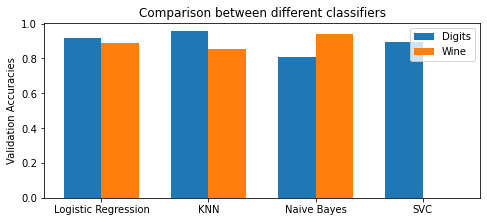

In [25]:
digits_validation_accuracies = [default_run[0],digits_knn_accuracy,digits_naive_accuracy,digits_svc_accuracy]
wine_validation_accuracies = [default_run[2],wine_knn_accuracy,wine_naive_accuracy,0]

labels = ["Logistic Regression","KNN","Naive Bayes","SVC"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, digits_validation_accuracies, width, label='Digits')
rects2 = ax.bar(x + width/2, wine_validation_accuracies, width, label='Wine')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Validation Accuracies')
ax.set_title('Comparison between different classifiers')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()
fig.set_size_inches(7,3)

plt.show()